In [1]:
from Modules import Ingenierie, data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay, calibration_curve
import requests
import json
import math
import wandb

/Users/yassine/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
year_list = range(2016,2020)
all_data=data.load_data(year_list)

Loading data for season 2016
Data for season 2016 loaded successfully.
Loading data for season 2017
Data for season 2017 loaded successfully.
Loading data for season 2018
Data for season 2018 loaded successfully.
Loading data for season 2019
Data for season 2019 loaded successfully.


In [3]:
# Process the loaded data
combined_shots_data = Ingenierie.process_loaded_games(all_data)
combined_shots_data.to_csv('dataframe/combined_shots_data.csv', index=False)

In [4]:
df = combined_shots_data 
df.head(5)

,shot_distance,shot_angle,is_goal,empty_net
0,51.429563,26.565051,0,0
1,30.083218,21.447736,0,0
2,13.000000,22.619865,0,0
3,33.060551,3.468229,0,0
4,38.078866,-13.671307,0,0


In [5]:
df_distance = df[['shot_distance']].dropna()
df_but = df[['is_goal']].dropna()
df_angle= df[['shot_angle']].dropna()
df_angle_distance = df[['shot_distance','shot_angle']].dropna()

df_distance_goal = df[["shot_distance", "is_goal"]].dropna()
df_angle_goal = df[["shot_angle", "is_goal"]].dropna()
df_angle_distance_goal = df[["shot_distance","shot_angle", "is_goal"]].dropna()

In [6]:
df_distance_goal.head(5)

,shot_distance,is_goal
0,51.429563,0
1,30.083218,0
2,13.000000,0
3,33.060551,0
4,38.078866,0


In [7]:
def random_baseline(X_train, y_train, X_valid, y_valid, name):
    # random predictions from a uniform distribution
    random_predictions = np.random.uniform(0, 1, len(X_valid))

    # Convert the random predictions to binary (0 or 1)
    threshold = 0.5
    y_pred = (random_predictions >= threshold).astype(int)

    # accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    print(f"Model {name} Accuracy: {accuracy:.2f}")

    return y_pred, random_predictions

def regression_logistique(X_train, y_train, X_valid, y_valid, model_name, model_type):
    # Dictionnaires pour les courbes ROC
    taux_faux_positif = dict()
    taux_vrai_positif = dict()
    aire_sous_courbe = dict()

    # Listes pour stocker les données
    liste_taux_faux_positif = []
    liste_taux_vrai_positif = []
    liste_aire_sous_courbe = []
    liste_caractéristiques = []

    # Listes pour les statistiques de buts et de tirs
    pourcentage_buts = []
    percentile = []
    cumul_but = []

    # List pour stocker les tags
    tags = []

    # -------- Modèle --------
    if model_type == 'logistic_regression':
        # Create an instance of Logistic Regression Classifier and fit the data.
        model = LogisticRegression().fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        predicted_prob = model.predict_proba(X_valid)
    elif model_type == 'random_baseline':
        # Your custom random baseline model here
        y_pred, predicted_prob = random_baseline(X_train, y_train, X_valid, y_valid, model_name)
    else:
        raise ValueError("Invalid model_type. Use 'logistic_regression' or 'random_baseline'.")

    acc = accuracy_score(y_valid, y_pred)
    print("Le score de précision de l'entraînement d'un classificateur de régression logistique en fonction de {} est : {}".format(model_name, acc))
    print("Les probabilités prédites sont : ")
    print(predicted_prob)

    accuracy = accuracy_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "f1": f1,
        "recall": recall,
    }
    params = {
            "model_type": 'Regression logistique sur {}'.format(model_name),
            "scaler": "standard scaler",
            "param_grid": str(model.get_params()) if model_type == 'logistic_regression' else "N/A",
    }


    # ROC
    if len(predicted_prob.shape) > 1 and predicted_prob.shape[1] > 1:
        p = predicted_prob[:, 1]
    else:
        p = predicted_prob
        
    taux_faux_positif, taux_vrai_positif, _ = roc_curve(y_valid, p)
    aire_sous_courbe = auc(taux_faux_positif, taux_vrai_positif)
    liste_taux_vrai_positif.append(taux_vrai_positif)
    liste_taux_faux_positif.append(taux_faux_positif)
    liste_aire_sous_courbe.append(aire_sous_courbe)
    liste_caractéristiques.append(model_name)

    # Goal Rate
    new_series = np.array(y_valid)
    new_series = np.reshape(new_series, (new_series.shape[0]))

    # Scale true_probabilities on percentile scale (0-100)
    true_prob = pd.DataFrame()
    true_prob['true_target'] = np.array(new_series)
    percentile = [[np.percentile(p, i), np.percentile(p, i+5)] 
                  for i in range(0,100,5)]

    # Loop on probabilities to check their percentiles with their status as goal/shot
    for i in range(len(percentile)):
        true_prob_percentile = true_prob[(p<=percentile[i][1]) & (p>percentile[i][0])]
        goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
        shots = true_prob_percentile.loc[true_prob_percentile['true_target']==0].shape[0]
        
        if goals == 0:
            pourcentage_buts.append(0)
        else:
            pourcentage_buts.append((goals*100)/(goals+shots))

    shot_prob_model_percentile = np.arange(0, 100, 5)

    # Cumulative 
    new_series = np.array(y_valid)
    new_series = np.reshape(new_series, (new_series.shape[0]))

    # Scale true_probabilities on percentile
    true_prob = pd.DataFrame()
    true_prob['true_target'] = np.array(new_series)
    percentile = [[np.percentile(p, i), np.percentile(p, i+1)] 
                  for i in range(0,100,1)]
    total_goal = np.sum(new_series)

    for i in range(0, len(percentile)-1):
        # We need previous and current goal lie in the percentile
        true_prob_percentile = true_prob[(p>=percentile[i][0])]
        goals = true_prob_percentile.loc[true_prob_percentile['true_target']==1].shape[0]
        # If no goal, do nothing, calculate the formula if goal
        cumul_but.append(goals*100/total_goal)
    cumul_but.append(0)

    # Axis for percentile
    shot_prob_model_percentile2 = np.arange(0, 100, 1)

    return taux_faux_positif, taux_vrai_positif, aire_sous_courbe, shot_prob_model_percentile, pourcentage_buts, y_pred, shot_prob_model_percentile2, cumul_but, p, metrics


# Regeression logistique sur la distance uniquement

In [8]:
X = df_distance_goal[['shot_distance']]
y = df_distance_goal['is_goal'] 


X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
model_distance=regression_logistique(X_train1, y_train1, X_valid1, y_valid1, 'distance','logistic_regression')

Le score de précision de l'entraînement d'un classificateur de régression logistique en fonction de distance est : 0.9486526979090929
Les probabilités prédites sont : 
[[0.96081887 0.03918113]
 [0.92067803 0.07932197]
 [0.93629274 0.06370726]
 ...
 [0.98307967 0.01692033]
 [0.94934518 0.05065482]
 [0.91756713 0.08243287]]


/Users/yassine/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
model_distance[9]

{'accuracy': 0.9486526979090929, 'precision': 0.0, 'f1': 0.0, 'recall': 0.0}

# Regression logistique sur l"angle uniquement

In [11]:
X2 = df_angle_goal[['shot_angle']].abs()
y2 = df_angle_goal['is_goal'] 
#df_angle_goal = df[["shot_angle", "is_goal"]].dropna()

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [12]:
model_angle=regression_logistique(X_train2, y_train2, X_valid2, y_valid2, 'angle','logistic_regression')

Le score de précision de l'entraînement d'un classificateur de régression logistique en fonction de angle est : 0.9489678234622198
Les probabilités prédites sont : 
[[0.94895514 0.05104486]
 [0.95872668 0.04127332]
 [0.95694162 0.04305838]
 ...
 [0.96049559 0.03950441]
 [0.94785276 0.05214724]
 [0.9417413  0.0582587 ]]


/Users/yassine/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Régression Logistique sur la distance et l'angle

In [13]:
#df_angle_distance_goal = df[["shot_distance","shot_angle", "is_goal"]].dropna()
X3 = df_angle_distance_goal[['shot_angle','shot_distance']]
X3.loc[:, 'shot_angle'] = X3['shot_angle'].abs()
y3 = df_angle_distance_goal['is_goal']  

X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [14]:
model_distance_angle=regression_logistique(X_train3, y_train3, X_valid3, y_valid3, 'distance_angle','logistic_regression')

Le score de précision de l'entraînement d'un classificateur de régression logistique en fonction de distance_angle est : 0.9489678234622198
Les probabilités prédites sont : 
[[0.96814745 0.03185255]
 [0.96234917 0.03765083]
 [0.96315912 0.03684088]
 ...
 [0.93452183 0.06547817]
 [0.98353801 0.01646199]
 [0.86982311 0.13017689]]


/Users/yassine/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# random baseline

In [15]:
# Define your features and target variable for the random baseline model
X_random = df_distance_goal[['shot_distance']]
y_random = df_distance_goal['is_goal']

# Split the data into training and validation sets
X_train_random, X_valid_random, y_train_random, y_valid_random = train_test_split(X_random, y_random, test_size=0.3, random_state=42)

# Create the random baseline model
model_random = regression_logistique(X_train1, y_train1, X_valid1, y_valid1,'random_baseline', model_type='random_baseline')

Model random_baseline Accuracy: 0.50
Le score de précision de l'entraînement d'un classificateur de régression logistique en fonction de random_baseline est : 0.5013605217352987
Les probabilités prédites sont : 
[0.45141549 0.04842833 0.96602829 ... 0.25177543 0.93878812 0.0243401 ]


# Figures

In [16]:
#Random Baseline
fpr_random, tpr_random, _ = roc_curve(y_valid1, model_random[5])
roc_auc_random = auc(fpr_random, tpr_random)

In [17]:
# Collecte des données pour les courbes ROC et AUC
# Collect data for ROC and AUC curves with expected key names
donnees_roc = {
    'taux_faux_positif': [model_distance[0], model_angle[0], model_distance_angle[0], fpr_random],
    'taux_vrai_positif': [model_distance[1], model_angle[1], model_distance_angle[1], tpr_random]
}
donnees_auc = {
    'aire_sous_courbe': [model_distance[2], model_angle[2], model_distance_angle[2], roc_auc_random]
}

In [18]:
import wandb

In [19]:
# Replace <run_id> with the actual ID of your existing run
wandb.init(project="IFT6758.2024-A", id="modeles_de_base_Q3", resume="allow")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yassine-faik (hicham-mazouzi-university-of-montreal). Use `wandb login --relogin` to force relogin


In [20]:
def courbe_roc_auc(modeles, donnees_roc, donnees_auc):
    etiquettes_modeles = ['Distance', 'Angle', 'Distance et Angle', 'Ligne de base aléatoire']
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    palette_couleurs = ['darkorange', 'green', 'navy', 'red']

    sns.set()
    
    for i in range(len(modeles)):
        ax = sns.lineplot(x=donnees_roc['taux_faux_positif'][i], y=donnees_roc['taux_vrai_positif'][i], color=palette_couleurs[i], lw=3,
                 label=f'{etiquettes_modeles[i]} (AUC = {round(donnees_auc["aire_sous_courbe"][i], 3)})', ax=ax)

       
    ax.plot([0, 1], [0, 1], color="black", lw=3, label="Ligne de base aléatoire idéale", linestyle="--")
    ax.legend(fontsize=12)
    ax.set_ylabel('Taux de vrais positifs', fontsize=18)
    ax.set_xlabel('Taux de faux positifs', fontsize=18)
    ax.set_title("Courbes ROC", fontsize=18)
    ax.tick_params(labelsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    #plt.show()
    plot_filename = "roc_curve_base.png"
    plt.savefig(plot_filename)
    #return fig
    return fig, plot_filename



def plot_taux_reussite_but(modeles, axes_x, axes_y):
    etiquettes_modeles = ['Distance', 'Angle', 'Distance et Angle', 'Ligne de base aléatoire']
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    palette_couleurs = ['darkorange', 'green', 'navy', 'red']

    for i in range(len(modeles)):
        ax = sns.lineplot(data={'x': axes_x[i], 'y': axes_y[i]},
                          x='x',
                          y='y',
                          label=f'{etiquettes_modeles[i]}',
                          color=palette_couleurs[i], legend=False, linewidth=3)

    sns.set()
    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=1)
    ax.legend(fontsize=12)
    ax.set_ylabel('But / (Tir + But)')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    ax.set_title(f"Taux de réussite des buts vs. Percentile du modèle de probabilité de tir")
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
    y_axis = [0,10,20,30,40,50,60,70,80,90,100]
    y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
    plt.yticks(y_axis, y_values)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    #plt.show()
    #return fig
    plot_filename = "goal_rate_plot.png"
    plt.savefig(plot_filename)
    plt.show()
    
    return fig, plot_filename



def plot_taux_reussite_cumulatif(modeles, axes_x, axes_y):
    etiquettes_modeles = ['Distance', 'Angle', 'Distance et Angle', 'Ligne de base aléatoire']
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    palette_couleurs = ['darkorange', 'green', 'navy', 'red']

    for i in range(len(modeles)):
        ax = sns.lineplot(data={'x': axes_x[i], 'y': axes_y[i]},
                          x='x',
                          y='y',
                          label=f'{etiquettes_modeles[i]}',
                          color=palette_couleurs[i], legend=False, linewidth=3)

    sns.set()
    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=100)
    ax.set_ylabel('Proportion de buts cumulés')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
    y_axis = [0,10,20,30,40,50,60,70,80,90,100]
    y_values = ['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
    plt.yticks(y_axis, y_values)
    ax.set_title(f"Taux de réussite cumulatif des buts vs. Percentile du modèle de probabilité de tir")
    ax.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    #plt.show()
    #return fig
    plot_filename = "cumulative_goal_rate_plot.png"
    plt.savefig(plot_filename)
    plt.show()
    
    return fig, plot_filename



def calibration_fig(y_val, y_pred_vec, model_names):

    fig, ax = plt.subplots(figsize=(7, 5))
    for idx, y_pred in enumerate(y_pred_vec):
        y_val_flat = np.ravel(y_val[idx])
        y_pred_flat = np.ravel(y_pred)
        disp = CalibrationDisplay.from_predictions(y_val_flat, y_pred_flat, n_bins=10, label=model_names[idx], ax=ax)

    sns.set()
    ax.set_ylabel("Fraction de positifs")
    ax.set_ylim([-0.05, 1.05])
    ax.set_title('Tracés de calibration (courbe de fiabilité)')
    ax.set_xlabel("Valeur moyenne prédite")
    ax.set_ylabel("Fraction de positifs")
    ax.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    #plt.show()
    #plt.close()
    #return fig
    plot_filename = "calibration_plot.png"
    plt.savefig(plot_filename)
    plt.show()
    
    return fig, plot_filename

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

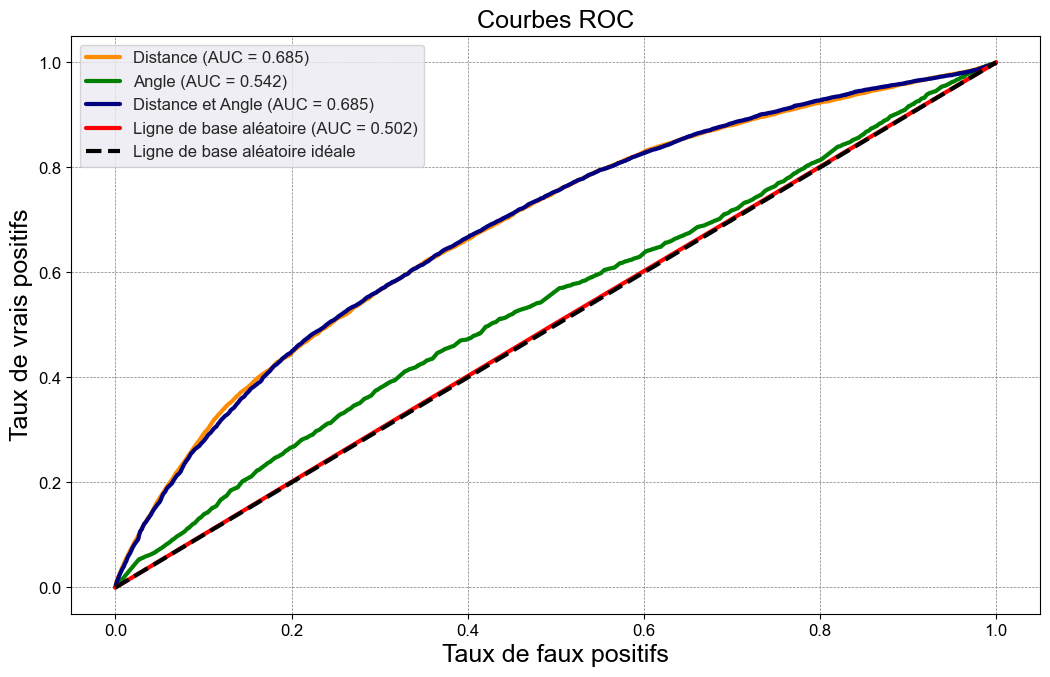

In [21]:
# Initialize Wandb
wandb.init(project="IFT6758.2024-A", name="roc_curve_base")

# Generate and log the ROC plot
roc_fig, roc_plot_filename = courbe_roc_auc(
    [model_distance, model_angle, model_distance_angle, 'Ligne de base aléatoire'], 
    donnees_roc, 
    donnees_auc
)

# Log the plot to Wandb
wandb.log({"ROC Curve": wandb.Image(roc_plot_filename)})

# Finish Wandb logging
wandb.finish()

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

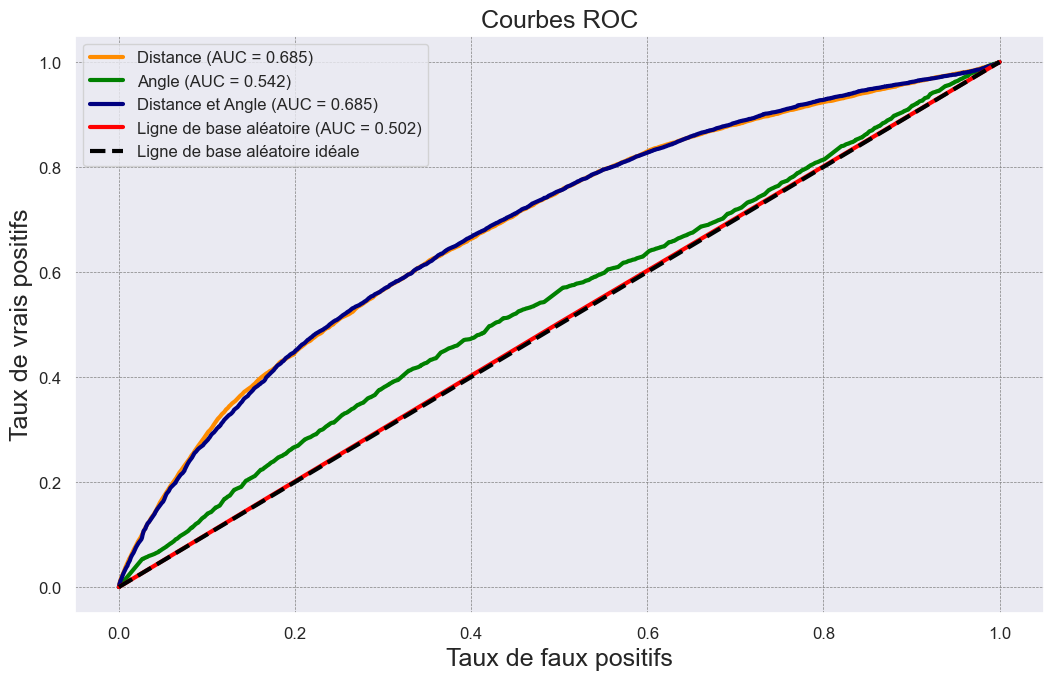

In [22]:
roc = courbe_roc_auc([model_distance, model_angle, model_distance_angle, 'Ligne de base aléatoire'], donnees_roc, donnees_auc)

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

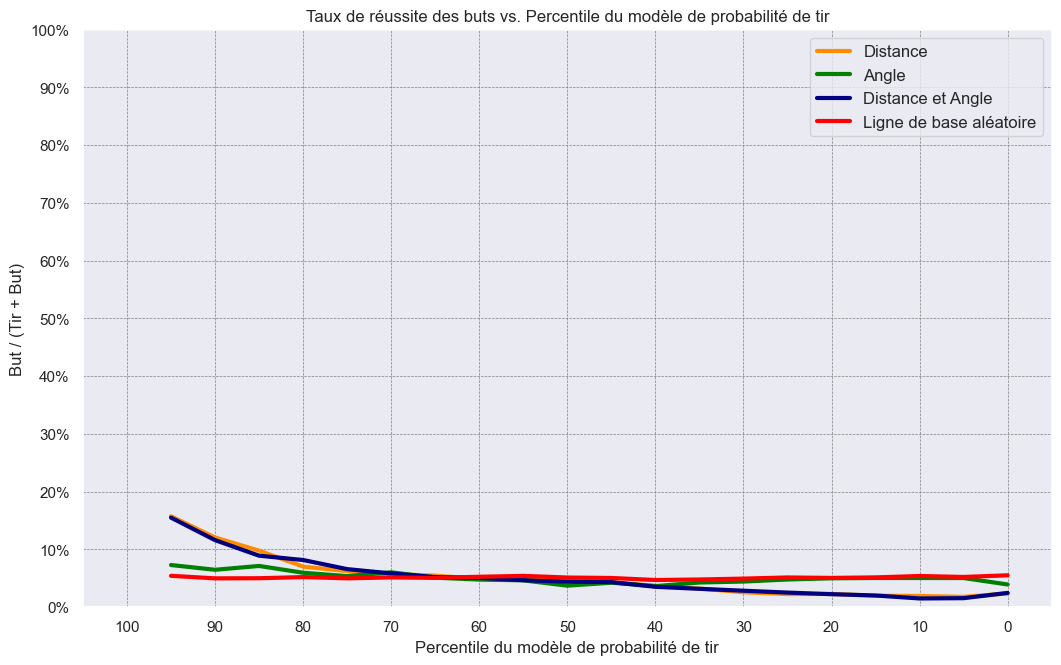

In [23]:
# Collecte des données pour les courbes de goal rate
axes_x = [model_distance[3], model_angle[3], model_distance_angle[3], model_distance[3]]
axes_y = [model_distance[4], model_angle[4], model_distance_angle[4], model_random[4]]

# Appel de la fonction pour tracer les courbes de goal rate en utilisant les objets de série Pandas
goal_rate = plot_taux_reussite_but([model_distance, model_angle, model_distance_angle, model_random], axes_x, axes_y)

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

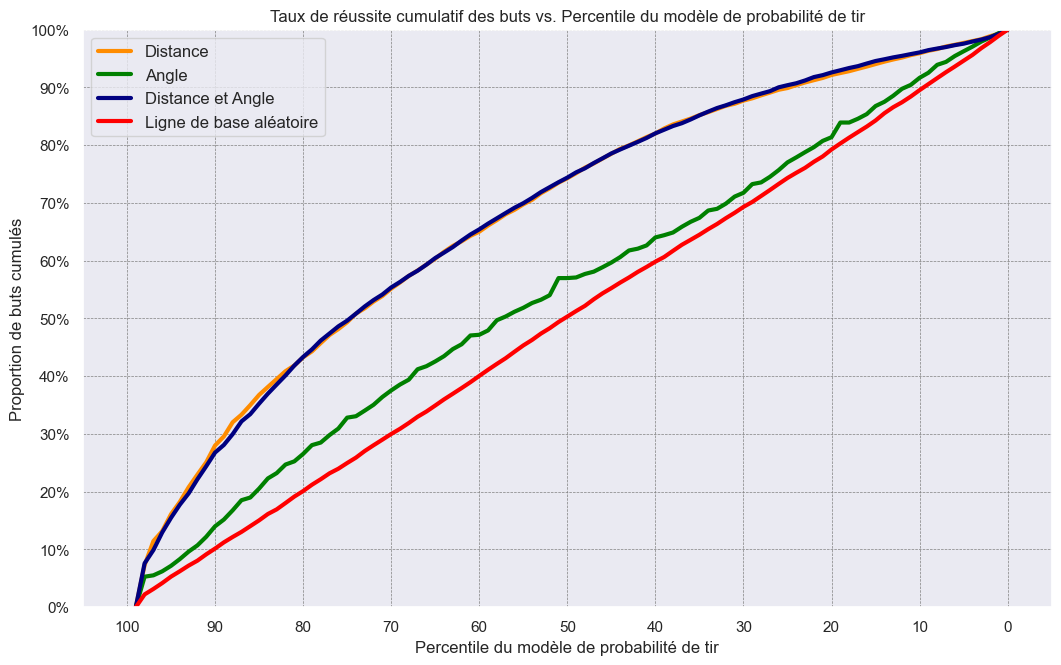

In [24]:
# Collecte des données pour les courbes de goal rate
axes_x2 = [model_distance[6], model_angle[6], model_distance_angle[6], model_distance[6]]
axes_y2 = [model_distance[7], model_angle[7], model_distance_angle[7], model_random[7]]

# Appel de la fonction pour tracer les courbes de goal rate en utilisant les objets de série Pandas
cumul_goal = plot_taux_reussite_cumulatif([model_distance, model_angle, model_distance_angle, model_random], axes_x2, axes_y2)

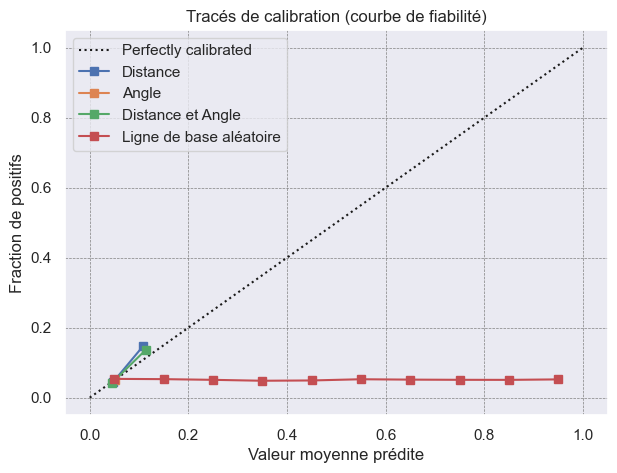

In [25]:
temp_y_pred = [model_distance[8], model_angle[8], model_distance_angle[8], model_random[8]]
temp_y_valid = [y_valid1, y_valid2, y_valid3, y_valid_random]
model_names = ['Distance', 'Angle', 'Distance et Angle', 'Ligne de base aléatoire']
calib = calibration_fig(temp_y_valid, temp_y_pred, model_names)

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

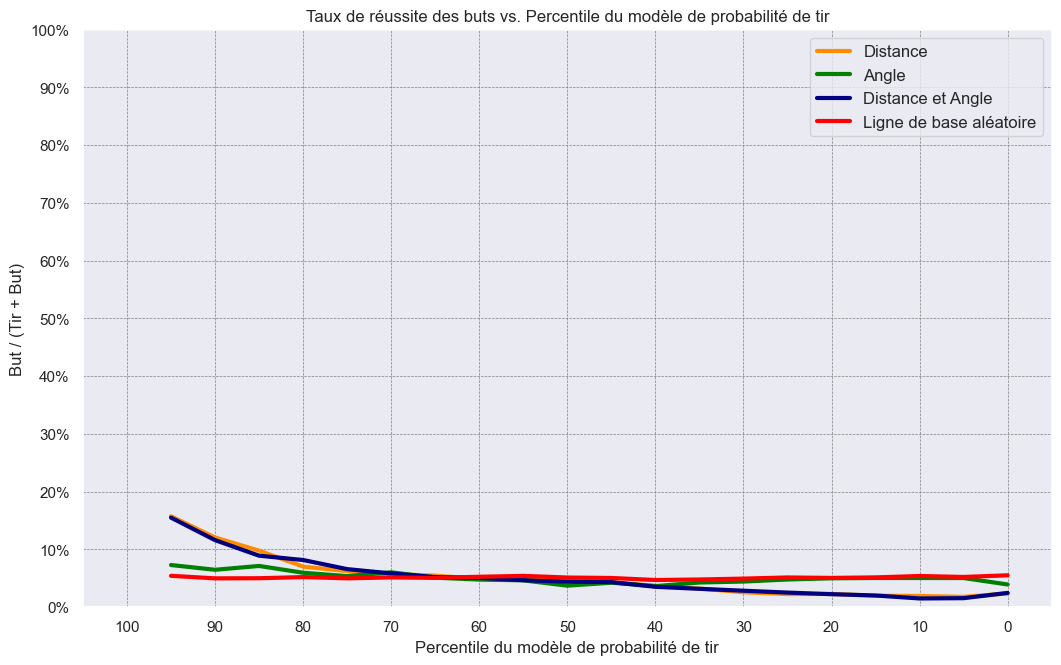

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

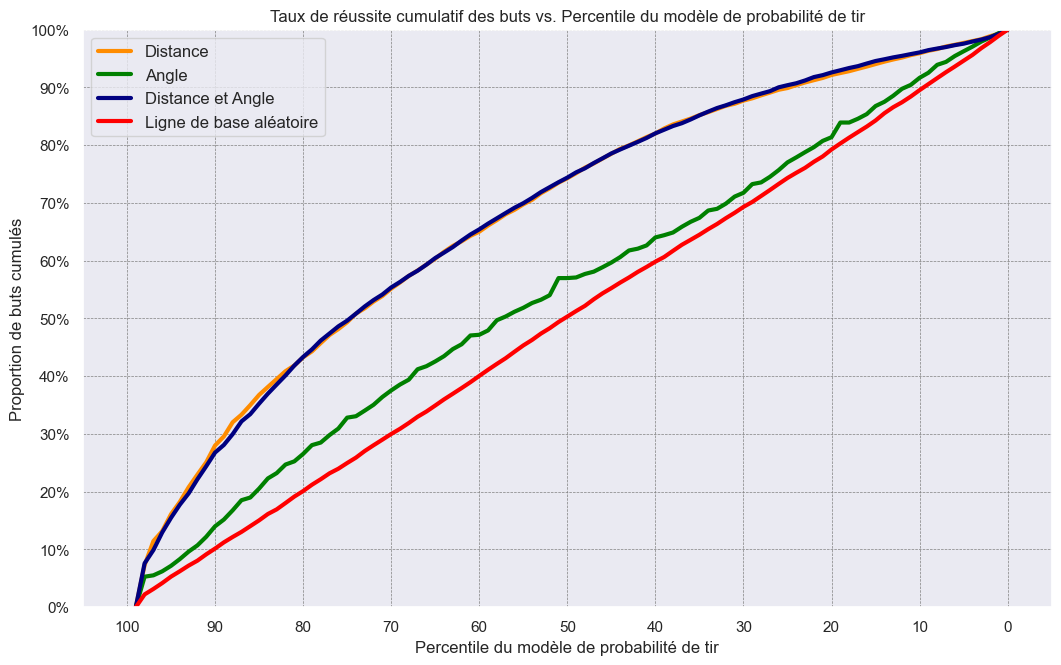

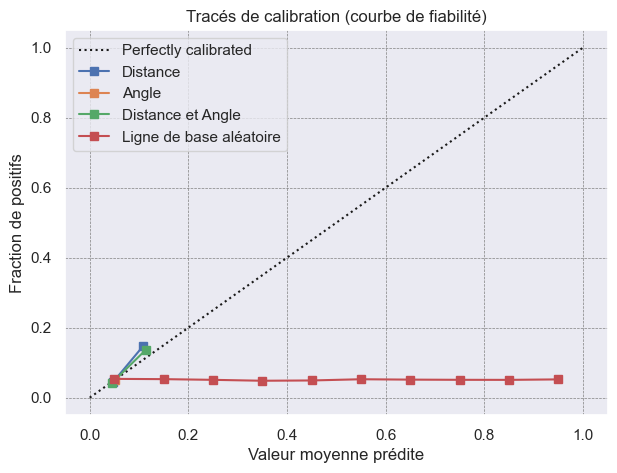

In [27]:
# Initialize Wandb
wandb.init(project="IFT6758.2024-A", name="extended_plots")

# Collect data for the plots (example input)
axes_x = [model_distance[3], model_angle[3], model_distance_angle[3], model_distance[3]]
axes_y = [model_distance[4], model_angle[4], model_distance_angle[4], model_random[4]]

# Plot goal success rate
goal_rate_fig, goal_rate_plot_filename = plot_taux_reussite_but(
    [model_distance, model_angle, model_distance_angle, model_random], axes_x, axes_y
)
wandb.log({"Goal Success Rate": wandb.Image(goal_rate_plot_filename)})

# Plot cumulative goal rate
axes_x2 = [model_distance[6], model_angle[6], model_distance_angle[6], model_distance[6]]
axes_y2 = [model_distance[7], model_angle[7], model_distance_angle[7], model_random[7]]

cumul_goal_fig, cumul_goal_plot_filename = plot_taux_reussite_cumulatif(
    [model_distance, model_angle, model_distance_angle, model_random], axes_x2, axes_y2
)
wandb.log({"Cumulative Goal Rate": wandb.Image(cumul_goal_plot_filename)})

# Plot calibration
temp_y_pred = [model_distance[8], model_angle[8], model_distance_angle[8], model_random[8]]
temp_y_valid = [y_valid1, y_valid2, y_valid3, y_valid_random]
model_names = ['Distance', 'Angle', 'Distance et Angle', 'Ligne de base aléatoire']

calib_fig, calib_plot_filename = calibration_fig(temp_y_valid, temp_y_pred, model_names)
wandb.log({"Calibration Curve": wandb.Image(calib_plot_filename)})

# Finalize Wandb
wandb.finish()